In [35]:
import json
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

seeds = []
for i in range(1, 101):
    seeds.append(i)


def time_to_minutes(timestr):
    # Handle '+1' suffix by removing it before parsing
    timestr = timestr.split('+')[0]  # Remove '+1' if present
    hh, mm = timestr.split(':')
    return int(hh) * 60 + int(mm)



def calculate_slack_for_scenario(scenario_data):
    """
    Calculate the slack metric for the given scenario.
    
    Slack is defined as:
        Slack = 1 - (total flight minutes in recovery period / total recovery period aircraft-minutes)
    
    A slack of 1 means no flights during recovery period.
    A slack of 0 means flights occupy the entire recovery period.
    """
    
    # Extract scenario start/end times
    # We assume the same date for start and end for simplicity.
    recovery_start_time_str = scenario_data["recovery_start_time"]  
    recovery_end_time_str = scenario_data["recovery_end_time"]      
    
    recovery_start_minutes = time_to_minutes(recovery_start_time_str)
    recovery_end_minutes = time_to_minutes(recovery_end_time_str)
    total_recovery_period_minutes = recovery_end_minutes - recovery_start_minutes
    
    total_aircraft = scenario_data["total_aircraft"]
    
    # Calculate total flight minutes within the recovery period
    flights = scenario_data["flights"]
    total_flights = len(flights)
    total_flight_minutes_in_recovery = 0
    total_flight_minutes_total = 0
    
    for flight_id, flight_data in flights.items():
        dep_time_str = flight_data["DepTime"]  
        arr_time_str = flight_data["ArrTime"] 
        
        dep_minutes = time_to_minutes(dep_time_str)
        arr_minutes = time_to_minutes(arr_time_str)
        
        total_flight_minutes_total += arr_minutes - dep_minutes
        overlap_start = max(dep_minutes, recovery_start_minutes)
        overlap_end = min(arr_minutes, recovery_end_minutes)
        
        if overlap_end > overlap_start:
            flight_overlap = overlap_end - overlap_start
        else:
            flight_overlap = 0
        
        total_flight_minutes_in_recovery += flight_overlap
    
    # Calculate total aircraft-minutes available during the recovery period
    total_recovery_aircraft_minutes = total_recovery_period_minutes * total_aircraft
    
    # Slack calculation
    if total_recovery_aircraft_minutes == 0:
        slack = 1.0
    else:
        slack = 1 - (total_flight_minutes_in_recovery / total_recovery_aircraft_minutes)
    
    return slack, total_flights, total_flight_minutes_total


def extract_disruption_stats(scenario_data):
    """
    Extract disruption statistics:
    - Count of fully disrupted (prob = 1.0)
    - Count of uncertain disruptions (0 < prob < 1.0)
    - Average probability across all aircraft (where an aircraft's probability is the max disruption probability it faces, 
      with 1.0 for fully disrupted and 0.0 if no disruption)
    - Average uncertainty probability (average of all disruptions where 0<prob<1.0, excluding 0 and 1)
    """
    disruptions_info = scenario_data.get('disruptions', {})
    disruptions_list = disruptions_info.get('disruptions', [])
    total_aircraft = disruptions_info.get('total_aircraft', 0)

    if total_aircraft == 0:
        # No aircraft or no disruptions
        return 0, 0, 0.0, 0.0

    fully_disrupted_count = sum(1 for d in disruptions_list if d.get('probability', 0.0) == 1.0)
    uncertain_disruptions = [d for d in disruptions_list if 0.0 < d.get('probability', 0.0) < 1.0]
    uncertain_count = len(uncertain_disruptions)

    aircraft_ids = scenario_data.get('aircraft_ids', [])
    ac_prob_map = {ac: 0.0 for ac in aircraft_ids}  
    
    for d in disruptions_list:
        ac_id = d.get('aircraft_id')
        p = d.get('probability', 0.0)
        # Keep the max probability for that aircraft
        if ac_id in ac_prob_map:
            ac_prob_map[ac_id] = max(ac_prob_map[ac_id], p)

    avg_ac_prob = sum(ac_prob_map.values()) / total_aircraft if total_aircraft > 0 else 0.0

    # Average uncertainty probability (only consider disruptions where 0<prob<1)
    if len(uncertain_disruptions) > 0:
        avg_uncertainty_prob = np.mean([d['probability'] for d in uncertain_disruptions])
    else:
        avg_uncertainty_prob = 0.0

    return fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertainty_prob, total_aircraft

# Path to the scenarios folder
scenario_folder_path = "../../logs/scenarios/"
# latest_folder = max(
#     [f for f in os.listdir(scenario_folder_path) if f.startswith("scenario_folder_")],
#     key=lambda x: int(x.split('_')[-1].replace('.json', ''))
# )

# latest_folder = "scenario_folder_scenario_74.json" # Training/6ac-10-superdiverse

# latest_folder = "scenario_folder_scenario_77.json" # Training/6ac-10000-superdiverse
latest_folder = "scenario_folder_scenario_4.json" # Testing/6ac-700-diverse

file_path = os.path.join(scenario_folder_path, latest_folder)

# Extract scenario ID
scenario_id = file_path.split('_')[-1].split('.')[0]
print(f"Scenario ID: {scenario_id}")

# Load the JSON data
with open(file_path, 'r') as file:
    data = json.load(file)

# Extract the scenarios from the JSON data
scenarios = data['outputs']


# Extract the data_folder (not strictly necessary for slack calculation, but we print it for context)
data_folder = data['data_folder']
print(f"Data Folder: {data_folder}")

# Calculate slack and disruption stats for each scenario and store in a list of dicts
results = []
for scenario_name, scenario_data in scenarios.items():
    scenario_slack, total_flights, total_flight_minutes_total = calculate_slack_for_scenario(scenario_data)
    fully_disrupted_count, uncertain_count, avg_ac_prob, avg_uncertain_prob, total_aircraft = extract_disruption_stats(scenario_data)
    results.append({
        "Scenario": scenario_name,
        "ScenarioSlack": scenario_slack,
        "TotalFlights": total_flights,
        "TotalFlightMinutes": total_flight_minutes_total,
        "FullyDisruptedCount": fully_disrupted_count,
        "UncertainCount": uncertain_count,
        "AvgAircraftProbability": avg_ac_prob,
        "AvgUncertaintyProbability": avg_uncertain_prob,
        "TotalAircraft": total_aircraft
    })

# Convert results to DataFrame
scenarios_df = pd.DataFrame(results)
print(scenarios_df)

# Save the slack results to CSV
# output_file = os.path.join(scenario_folder_path, f"scenario_slack_metrics_{scenario_id}.csv")
# scenarios_df.to_csv(output_file, index=False)
# print(f"Slack metrics saved to {output_file}")


Scenario ID: 4
Data Folder: ../data/Testing/6ac-700-diverse/
                          Scenario  ScenarioSlack  TotalFlights  \
0    deterministic_na_Scenario_001       0.349048            21   
1    deterministic_na_Scenario_002       0.369713            21   
2    deterministic_na_Scenario_003       0.420513            13   
3    deterministic_na_Scenario_004       0.441493            16   
4    deterministic_na_Scenario_005       0.484896            14   
..                             ...            ...           ...   
695        mixed_high_Scenario_096       0.479683            15   
696        mixed_high_Scenario_097       0.460082            13   
697        mixed_high_Scenario_098       0.424324            20   
698        mixed_high_Scenario_099       0.407037            15   
699        mixed_high_Scenario_100       0.428228            18   

     TotalFlightMinutes  FullyDisruptedCount  UncertainCount  \
0                  4101                    2               0   
1     

<div class="alert alert-block alert-success">
</br>
</br>
</br>
<b>DONE: </b>MERGED DATASET
</br>
</br>
</br>
</br>
</div>

In [36]:
import os
import pandas as pd

scenario_folder_path = "../../logs/scenarios/"
# unpack results_df
results_df = pd.read_csv(os.path.join(scenario_folder_path, f"final_final_results_df_in_rapport_seeds_{len(seeds)}.csv"))


# Merge scenario-level info from scenarios_df into results_df
merged_df = results_df.merge(scenarios_df, on='Scenario', how='left')

# Add scenario category based on prefix and difficulty level
merged_df["ScenarioCategory"] = merged_df["Scenario"].apply(
    lambda x: "Deterministic" if x.startswith("deterministic") else
             "Stochastic High" if x.startswith("stochastic_high") else
             "Stochastic Medium" if x.startswith("stochastic_medium") else
             "Stochastic Low" if x.startswith("stochastic_low") else
             "Mixed High" if x.startswith("mixed_high") else
             "Mixed Medium" if x.startswith("mixed_medium") else
             "Mixed Low" if x.startswith("mixed_low") else
             "Other"
)

# Sort models in desired order
model_order = ['proactive', 'myopic', 'reactive', 'greedy_reactive']
merged_df['Model_Type'] = merged_df['Model'].str.extract('(' + '|'.join(model_order) + ')')
merged_df = merged_df.sort_values('Model_Type')
merged_df["Model"] = merged_df["Model_Type"]
merged_df = merged_df.drop('Model_Type', axis=1)
merged_df_backup = merged_df.copy()


# Update model names in merged_df
merged_df['Model'] = merged_df['Model'].apply(lambda x: 
    'DQN Proactive-U' if x.startswith('proactive') else
    'DQN Proactive-N' if x.startswith('myopic') else 
    'DQN Reactive' if x.startswith('reactive') else
    'Greedy Reactive' if x.startswith('greedy_reactive') else
    x
)

print("Inference Results (After Merging):")
print(merged_df)

# Save the merged results to CSV
merged_output_file = os.path.join(scenario_folder_path, f"scenario_inference_metrics_{scenario_id}.csv")
merged_df.to_csv(merged_output_file, index=False)
print(f"Inference results with scenario info saved to {merged_output_file}")



# print all column names
print("==== Columns: ====")
print(merged_df.columns)

print("==== amount of rows: ====")
print(len(merged_df))

print("==== Models: ====")
print(merged_df["Model"].unique())

print('===== len(seeds) =====')
print(len(merged_df['Seed'].unique()))

print('===== len(scenarios) =====')
print(len(merged_df['Scenario'].unique()))


Inference Results (After Merging):
                              Scenario            Model  Seed  TotalReward  \
139999     stochastic_low_Scenario_093  Greedy Reactive   100       -217.6   
130773          mixed_low_Scenario_063  Greedy Reactive    74      24786.2   
130772          mixed_low_Scenario_063  Greedy Reactive    73      24786.2   
130771          mixed_low_Scenario_063  Greedy Reactive    72      19799.3   
130770          mixed_low_Scenario_063  Greedy Reactive    71      19799.3   
...                                ...              ...   ...          ...   
222263  stochastic_medium_Scenario_085     DQN Reactive    64       9612.9   
222262  stochastic_medium_Scenario_085     DQN Reactive    63       -217.0   
222261  stochastic_medium_Scenario_085     DQN Reactive    62       -217.0   
222268  stochastic_medium_Scenario_085     DQN Reactive    69       9612.9   
35000      stochastic_low_Scenario_091     DQN Reactive     1        -90.8   

        TotalDelays  TotalCa

<div class="alert alert-block alert-info">
<b>Check: </b>Comparison of Models Across All Scenarios
</div>

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Define model colors and order
model_colors = {
    'DQN Proactive-U': ('orange', 'DQN Proactive-U'),
    'DQN Proactive-N': ('blue', 'DQN Proactive-N'),
    'DQN Reactive': ('green', 'DQN Reactive'),
    'Greedy Reactive': ('darkgrey', 'Greedy Reactive')
}

# First aggregate by Model and Seed, then calculate mean and std across seeds
comparison_table = (
    merged_df
    .groupby(['Model', 'Seed'])
    .agg(
        TotalReward=('TotalReward', 'mean'),
        ScenarioTime=('ScenarioTime', 'mean'), 
        ScenarioSteps=('ScenarioSteps', 'mean'),
        TotalDelays=('TotalDelays', 'mean'),
        TotalCancelledFlights=('TotalCancelledFlights', 'mean'),
        TotalTailSwaps=('TailSwaps', 'mean')
    )
    .groupby('Model')
    .agg(
        Mean_Reward=('TotalReward', 'mean'),
        Std_Reward=('TotalReward', 'std'),
        Mean_Runtime=('ScenarioTime', 'mean'),
        Std_Runtime=('ScenarioTime', 'std'),
        Mean_Steps=('ScenarioSteps', 'mean'),
        Std_Steps=('ScenarioSteps', 'std'),
        Mean_Delays=('TotalDelays', 'mean'),
        Std_Delays=('TotalDelays', 'std'),
        Mean_CancelledFlights=('TotalCancelledFlights', 'mean'),
        Std_CancelledFlights=('TotalCancelledFlights', 'std'),
        Mean_TailSwaps=('TotalTailSwaps', 'mean'),
        Std_TailSwaps=('TotalTailSwaps', 'std')
    )
    .round(2)
)

# Sort the comparison table according to specified order
model_order = ['Greedy Reactive', 'DQN Reactive', 'DQN Proactive-N', 'DQN Proactive-U']
comparison_table = comparison_table.reindex(model_order)

print("Comparison of Models Across All Scenarios:")
print(comparison_table)


Comparison of Models Across All Scenarios:
                 Mean_Reward  Std_Reward  Mean_Runtime  Std_Runtime  \
Model                                                                 
Greedy Reactive     32888.75      403.08          0.17          0.0   
DQN Reactive        -4062.91      443.99          0.03          0.0   
DQN Proactive-N      6198.37      474.22          0.03          0.0   
DQN Proactive-U     10186.83      535.50          0.03          0.0   

                 Mean_Steps  Std_Steps  Mean_Delays  Std_Delays  \
Model                                                             
Greedy Reactive        6.89       0.02        19.58        2.53   
DQN Reactive           7.95       0.04       226.31        5.54   
DQN Proactive-N        7.52       0.03       343.03        4.18   
DQN Proactive-U        7.44       0.03       301.04        3.25   

                 Mean_CancelledFlights  Std_CancelledFlights  Mean_TailSwaps  \
Model                                          

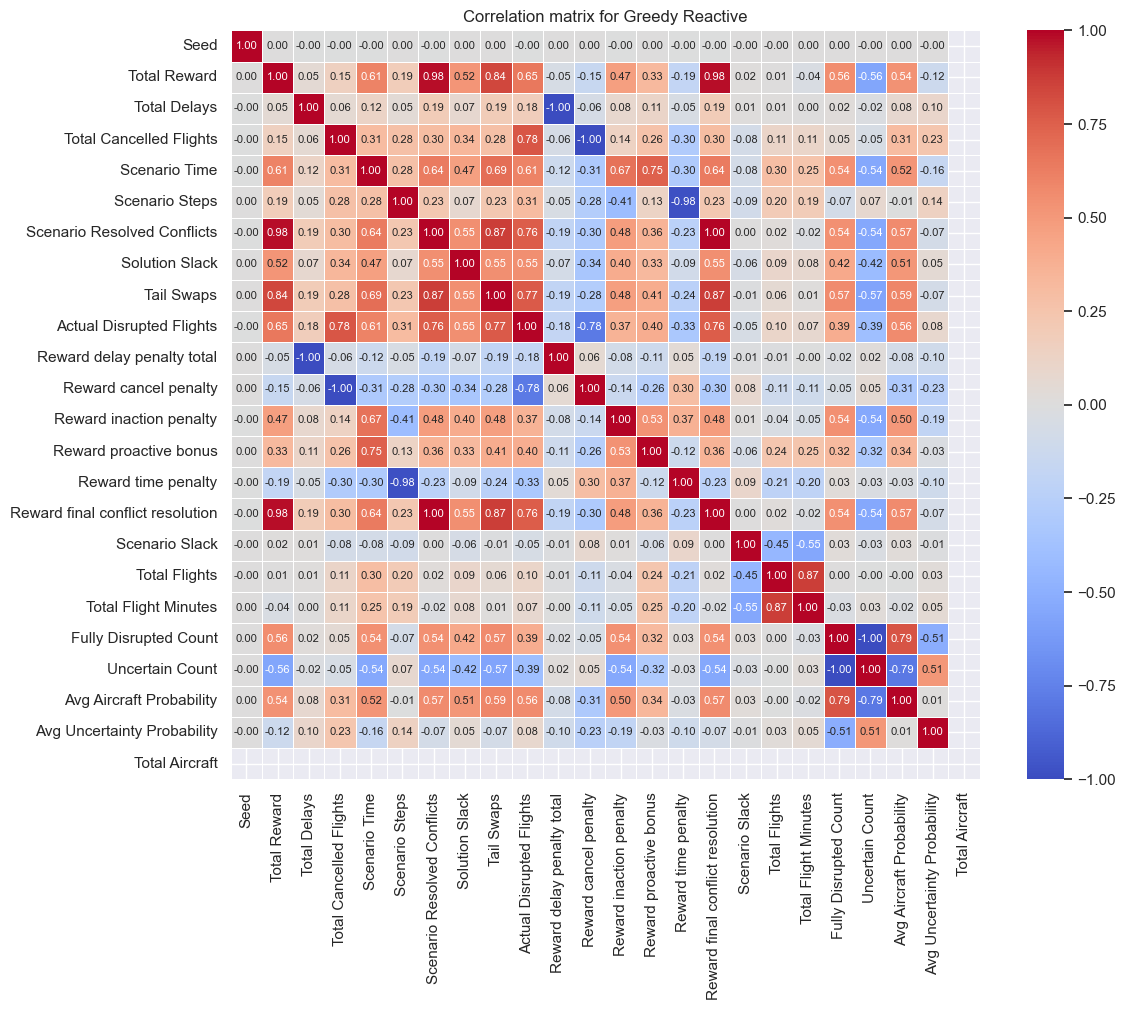

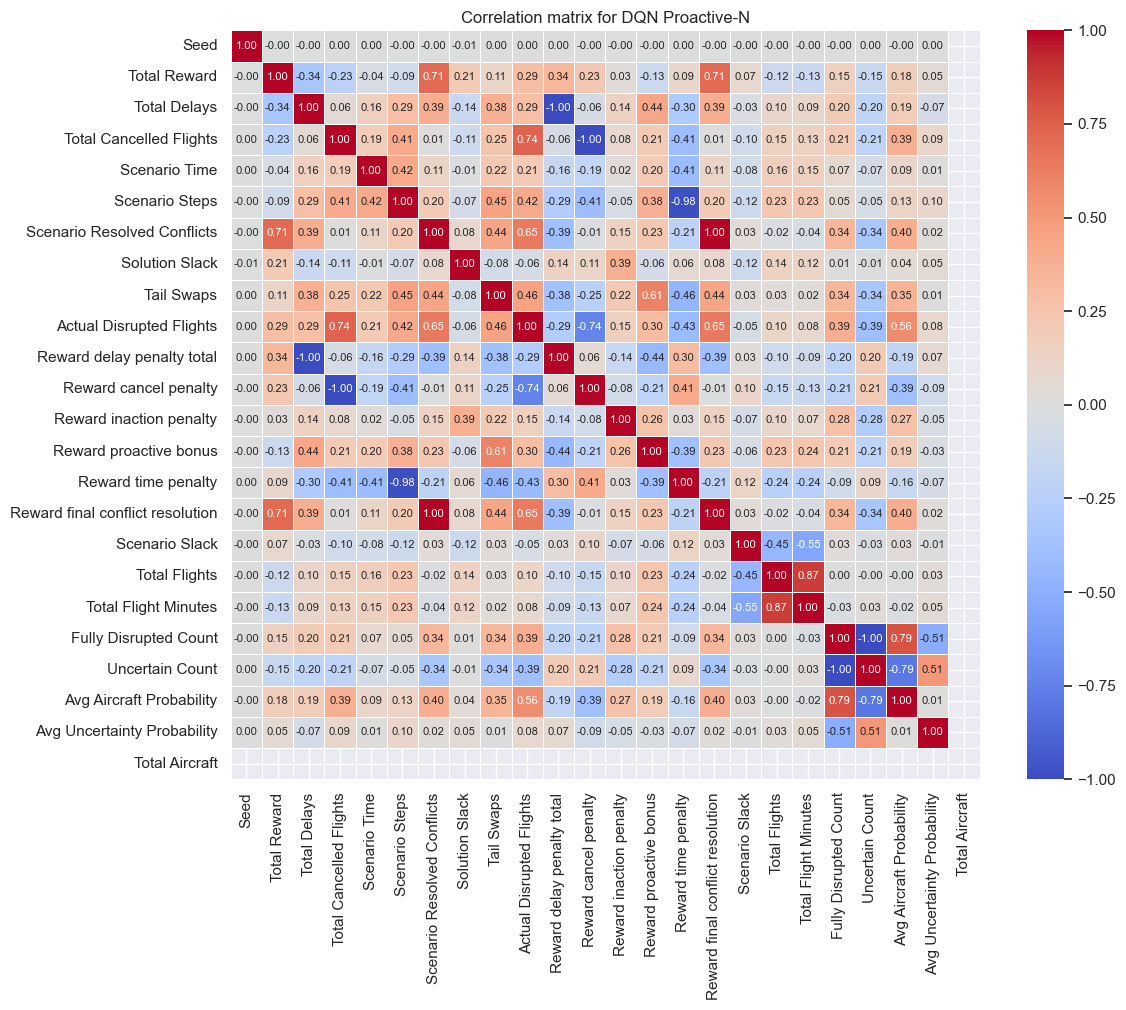

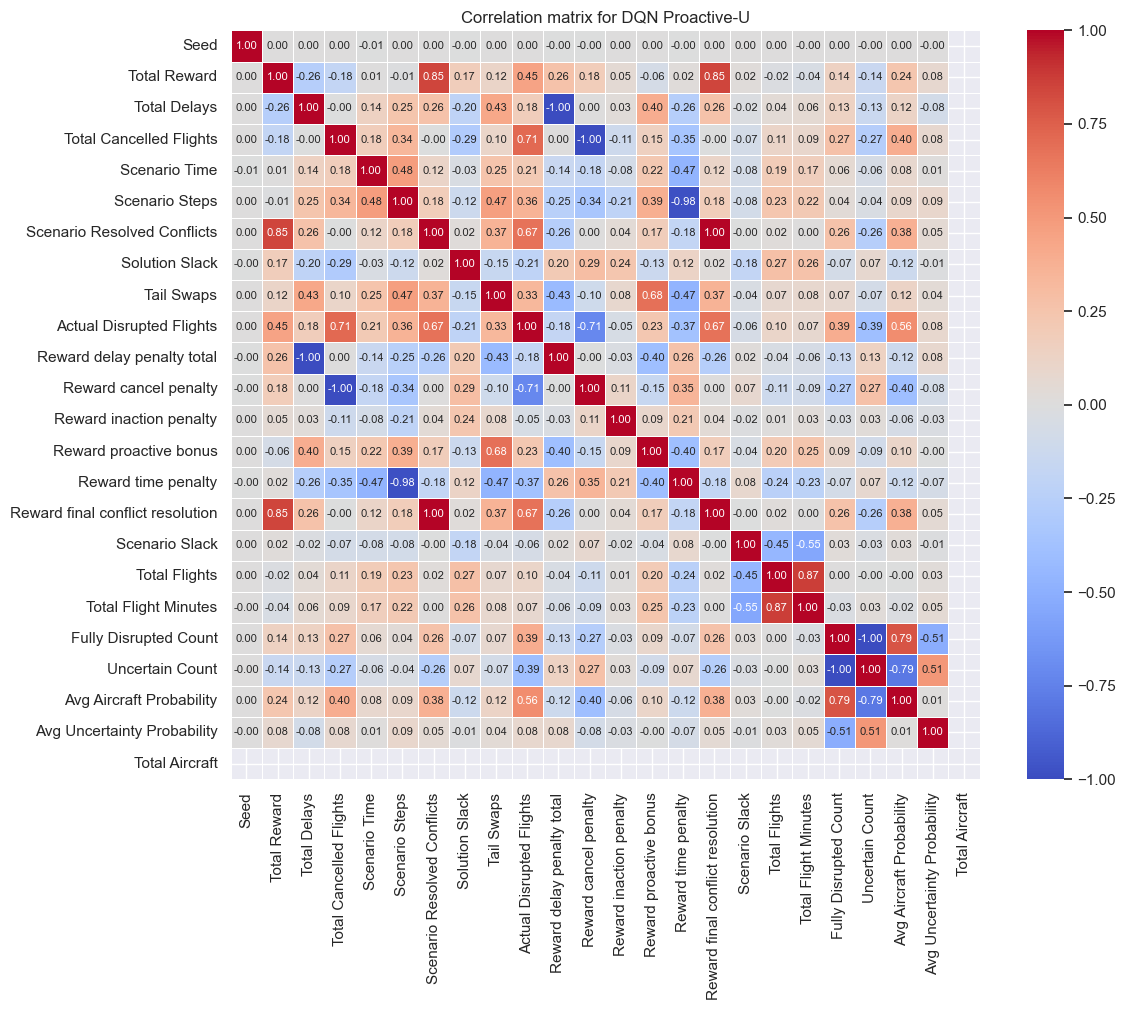

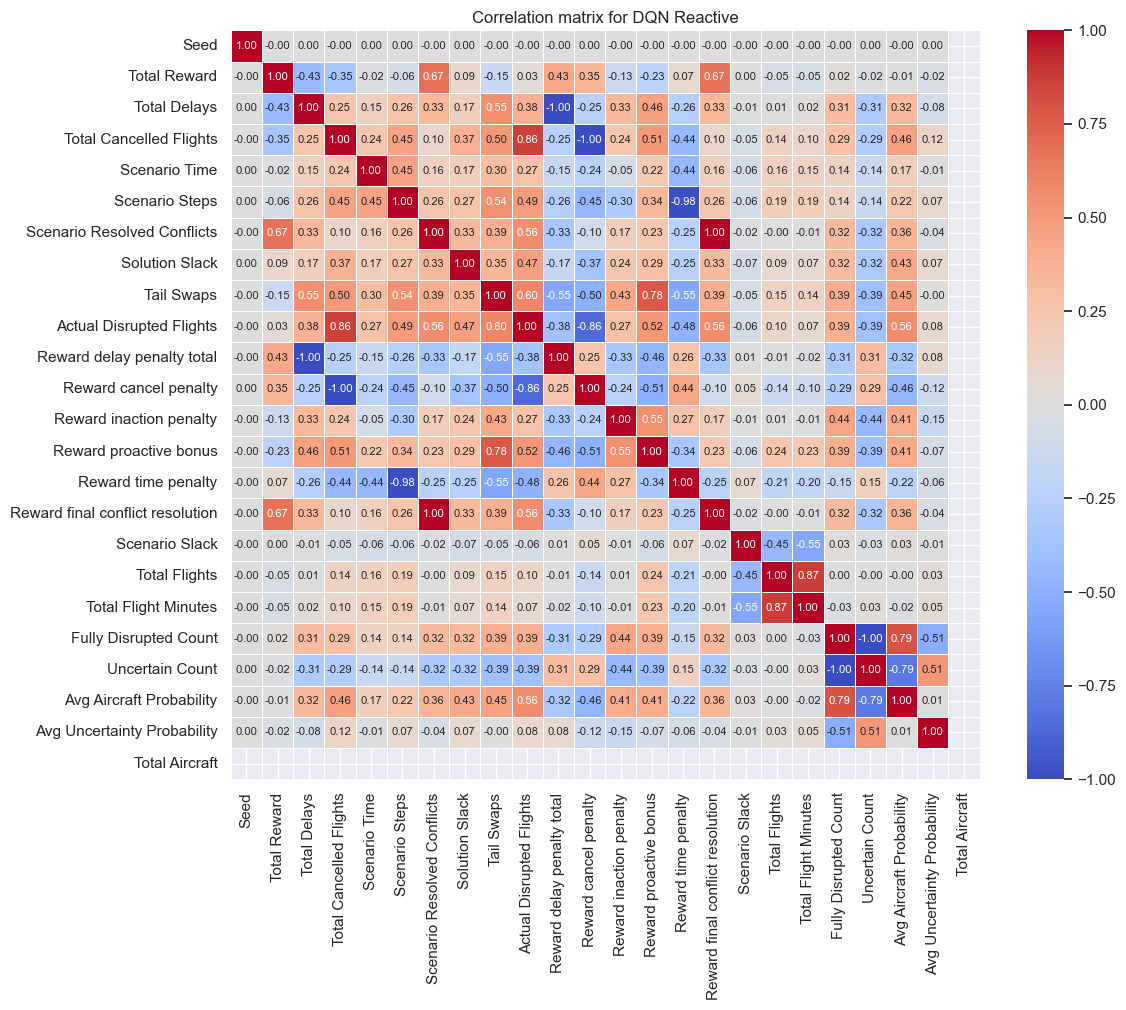

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Filter out non-numeric columns and format column names
def format_columns(df):
    formatted_columns = []
    for col in df.columns:
        # Replace underscores with spaces
        col = col.replace('_', ' ')
        # Add space between lowercase followed by uppercase
        formatted = ''.join([' ' + c if i > 0 and c.isupper() and col[i-1].islower() else c 
                            for i, c in enumerate(col)])
        # Remove second instance of "Reward" if it appears twice
        if formatted.lower().count('reward') > 1:
            first_reward = formatted.lower().find('reward')
            formatted = formatted[:first_reward+6] + re.sub('reward', '', formatted[first_reward+6:], flags=re.IGNORECASE)
        # Remove trailing and leading spaces after all operations
        formatted = formatted.strip()
        formatted_columns.append(formatted)
    return formatted_columns

# Create separate correlation matrices for each model
for model in merged_df['Model'].unique():
    model_df = merged_df[merged_df['Model'] == model]
    numeric_df = model_df.select_dtypes(include=['int64', 'float64'])
    numeric_df.columns = format_columns(numeric_df)
    
    plt.figure(figsize=(12, 10))
    correlation_matrix = numeric_df.corr()
    
    sns.heatmap(correlation_matrix,
                annot=True,  # Show correlation values
                cmap='coolwarm',  # Color scheme
                center=0,  # Center the colormap at 0
                square=True,  # Make cells square
                fmt='.2f',  # Round to 2 decimal places
                linewidths=0.5,  # Add gridlines
                annot_kws={'size': 8})  # Make annotation font size smaller
    plt.title(f'Correlation matrix for {model}')
    plt.tight_layout()
    plt.show()


In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np
from scipy import stats

# Filter to the two models of interest
df_filtered = merged_df[merged_df["Model"].isin(["DQN Proactive-U", "DQN Proactive-N"])].copy()

# Calculate correlations for each model separately
df_reactive = df_filtered[df_filtered["Model"] == "DQN Proactive-N"].copy()
df_proactive = df_filtered[df_filtered["Model"] == "DQN Proactive-U"].copy()

# Define metrics and predictors
metrics = ["TotalCancelledFlights", "TotalDelays", "TailSwaps"]
predictors = [
    "ActualDisruptedFlights", "ScenarioSlack", "TotalFlights",
    "TotalFlightMinutes", "FullyDisruptedCount", "UncertainCount",
    "AvgAircraftProbability", "AvgUncertaintyProbability", "TotalAircraft"
]

# Scale the data for each model
scaler = StandardScaler()
reactive_scaled = pd.DataFrame(
    scaler.fit_transform(df_reactive[predictors + metrics]),
    columns=predictors + metrics
)

proactive_scaled = pd.DataFrame(
    scaler.fit_transform(df_proactive[predictors + metrics]),
    columns=predictors + metrics
)

# Calculate correlations
reactive_corr = reactive_scaled.corr()
proactive_corr = proactive_scaled.corr()

print("\n=== Detailed Summary ===")
for metric in metrics:
    print(f"\n{metric}:")
    print(f"{'Predictor':<25} | {'DQN Proactive-N':>12} | {'DQN Proactive-U':>15} | {'Diff':>8} | {'p-value':>10} | Interpretation")
    print("-" * 100)
    
    for predictor in predictors:
        # Get correlations
        reactive_val = reactive_corr.loc[predictor, metric]
        proactive_val = proactive_corr.loc[predictor, metric]
        diff = proactive_val - reactive_val
        
        # Fisher Z-transformation
        z1 = np.arctanh(reactive_val)
        z2 = np.arctanh(proactive_val)
        
        # Calculate standard error
        n1 = len(df_reactive)
        n2 = len(df_proactive)
        se = np.sqrt(1/(n1-3) + 1/(n2-3))
        
        # Calculate z-statistic and p-value
        z = (z1 - z2) / se
        p_value = 2 * (1 - stats.norm.cdf(abs(z)))
        
        # Determine interpretation
        if p_value < 0.05:
            if abs(proactive_val) > abs(reactive_val):
                interpretation = "DQN Proactive-U is more sensitive"
            else:
                interpretation = "DQN Proactive-N is more sensitive"
        else:
            interpretation = "No significant difference"
            
        print(f"{predictor:<25} | {reactive_val:12.3f} | {proactive_val:15.3f} | {diff:8.3f} | {p_value:10.3f} | {interpretation}")



=== Detailed Summary ===

TotalCancelledFlights:
Predictor                 | DQN Proactive-N | DQN Proactive-U |     Diff |    p-value | Interpretation
----------------------------------------------------------------------------------------------------
ActualDisruptedFlights    |        0.740 |           0.712 |   -0.028 |      0.000 | DQN Proactive-N is more sensitive
ScenarioSlack             |       -0.098 |          -0.071 |    0.027 |      0.000 | DQN Proactive-N is more sensitive
TotalFlights              |        0.149 |           0.113 |   -0.036 |      0.000 | DQN Proactive-N is more sensitive
TotalFlightMinutes        |        0.133 |           0.093 |   -0.039 |      0.000 | DQN Proactive-N is more sensitive
FullyDisruptedCount       |        0.210 |           0.268 |    0.058 |      0.000 | DQN Proactive-U is more sensitive
UncertainCount            |       -0.210 |          -0.268 |   -0.058 |      0.000 | DQN Proactive-U is more sensitive
AvgAircraftProbability    |     

In [40]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as nps
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to the two models of interest and stochastic scenarios
df_filtered = merged_df[
    (merged_df["Model"].isin(["DQN Proactive-U", "DQN Proactive-N"]))  &
    (merged_df["Scenario"].str.startswith(("stochastic", "mixed")))
].copy()

# Calculate correlations for each model separately
df_reactive = df_filtered[df_filtered["Model"] == "DQN Proactive-N"].copy()
df_proactive = df_filtered[df_filtered["Model"] == "DQN Proactive-U"].copy()

# Define metrics and predictors
metrics = ["TotalCancelledFlights", "TotalDelays", "TailSwaps"]
predictors = ["AvgUncertaintyProbability", "ActualDisruptedFlights"]

# Print distribution statistics
print("\n=== AvgUncertaintyProbability Distribution ===")
print("\nDQN Proactive-N:")
print(df_reactive["AvgUncertaintyProbability"].describe())
print("\nDQN Proactive-U:")
print(df_proactive["AvgUncertaintyProbability"].describe())

# Print counts of scenarios with and without disruptions
print("\n=== Scenario Counts ===")
print("\nDQN Proactive-N:")
print(f"Without disruptions: {len(df_reactive[df_reactive['ActualDisruptedFlights'] == 0])}")
print(f"With disruptions: {len(df_reactive[df_reactive['ActualDisruptedFlights'] > 0])}")
print("\nDQN Proactive-U:")
print(f"Without disruptions: {len(df_proactive[df_proactive['ActualDisruptedFlights'] == 0])}")
print(f"With disruptions: {len(df_proactive[df_proactive['ActualDisruptedFlights'] > 0])}")

# Scale the data for each model
scaler = StandardScaler()
reactive_scaled = pd.DataFrame(
    scaler.fit_transform(df_reactive[predictors + metrics]),
    columns=predictors + metrics
)

proactive_scaled = pd.DataFrame(
    scaler.fit_transform(df_proactive[predictors + metrics]),
    columns=predictors + metrics
)

# Calculate correlations
reactive_corr = reactive_scaled.corr()
proactive_corr = proactive_scaled.corr()

print("\n=== Average Metrics Summary (Stochastic Scenarios) ===")
for metric in metrics:
    reactive_mean = df_reactive[metric].mean()
    proactive_mean = df_proactive[metric].mean()
    diff = proactive_mean - reactive_mean
    
    # Calculate means and perform t-tests for when ActualDisruptedFlights is 0 and non-zero
    reactive_zero = df_reactive[df_reactive["ActualDisruptedFlights"] == 0][metric]
    proactive_zero = df_proactive[df_proactive["ActualDisruptedFlights"] == 0][metric]
    reactive_mean_zero = reactive_zero.mean()
    proactive_mean_zero = proactive_zero.mean()
    diff_zero = proactive_mean_zero - reactive_mean_zero
    _, p_zero = stats.ttest_ind(reactive_zero, proactive_zero)
    
    reactive_nonzero = df_reactive[df_reactive["ActualDisruptedFlights"] > 0][metric]
    proactive_nonzero = df_proactive[df_proactive["ActualDisruptedFlights"] > 0][metric]
    reactive_mean_nonzero = reactive_nonzero.mean()
    proactive_mean_nonzero = proactive_nonzero.mean()
    diff_nonzero = proactive_mean_nonzero - reactive_mean_nonzero
    _, p_nonzero = stats.ttest_ind(reactive_nonzero, proactive_nonzero)
    
    print(f"\n{metric}:")
    print(f"{'Model':<20} | {'No Disruptions':>15} | {'With Disruptions':>15}")
    print("-" * 55)
    print(f"{'DQN Proactive-N':<20} | {reactive_mean_zero:15.2f} | {reactive_mean_nonzero:15.2f}")
    print(f"{'DQN Proactive-U':<20} | {proactive_mean_zero:15.2f} | {proactive_mean_nonzero:15.2f}")
    print(f"{'Difference':<20} | {diff_zero:15.2f} (p={p_zero:.3f}) | {diff_nonzero:15.2f} (p={p_nonzero:.3f})")


# Find scenarios that meet the criteria
scenarios = []
for scenario in df_reactive["Scenario"].unique():
    if not scenario.startswith("mixed"):
        continue
        
    reactive_row = df_reactive[df_reactive["Scenario"] == scenario]
    proactive_row = df_proactive[df_proactive["Scenario"] == scenario]
    
    if len(reactive_row) > 0 and len(proactive_row) > 0:
        if (reactive_row["ActualDisruptedFlights"].values[0] > 2 and 
            proactive_row["TotalCancelledFlights"].values[0] < reactive_row["TotalCancelledFlights"].values[0]):
            
            total_reward = (proactive_row["TotalReward"].values[0] + reactive_row["TotalReward"].values[0])
            scenarios.append((scenario, total_reward, 
                            proactive_row["TotalCancelledFlights"].values[0],
                            reactive_row["TotalCancelledFlights"].values[0],
                            reactive_row["ActualDisruptedFlights"].values[0]))
if scenarios:
    # Sort by highest combined total reward
    scenarios.sort(key=lambda x: x[1], reverse=True)
    print("\nTop 1 scenarios with more than 2 disruptions and fewer proactive cancellations (sorted by total reward):")
    print(f"{'Scenario':<30} | {'Total Reward':>12} | {'Pro-U Canc':>8} | {'Pro-N Canc':>8} | {'Disrupted':>9}")
    print("-" * 75)
    
    # Only show top 5
    for scenario, total_reward, pro_canc, re_canc, disrupted in scenarios[:1]:
        print(f"{scenario:<30} | {total_reward:>12.2f} | {pro_canc:>8} | {re_canc:>8} | {disrupted:>9}")
        
        # Get detailed metrics for this scenario
        reactive_row = df_reactive[df_reactive["Scenario"] == scenario].iloc[0]
        proactive_row = df_proactive[df_proactive["Scenario"] == scenario].iloc[0]
        
        print("\nDetailed metrics:")
        print(f"{'Model':<15} | {'Cancellations':>12} | {'Delays (min)':>12} | {'Tail Swaps':>10} | {'Disrupted':>9}")
        print("-" * 65)
        print(f"{'DQN Pro-N':<15} | {reactive_row['TotalCancelledFlights']:>12} | "
              f"{reactive_row['TotalDelays']:>12.0f} | {reactive_row['TailSwaps']:>10} | "
              f"{reactive_row['ActualDisruptedFlights']:>9}")
        print(f"{'DQN Pro-U':<15} | {proactive_row['TotalCancelledFlights']:>12} | "
              f"{proactive_row['TotalDelays']:>12.0f} | {proactive_row['TailSwaps']:>10} | "
              f"{proactive_row['ActualDisruptedFlights']:>9}")
        print()



=== AvgUncertaintyProbability Distribution ===

DQN Proactive-N:
count    60000.000000
mean         0.504639
std          0.191946
min          0.107905
25%          0.349198
50%          0.502235
75%          0.654804
max          0.897749
Name: AvgUncertaintyProbability, dtype: float64

DQN Proactive-U:
count    60000.000000
mean         0.504639
std          0.191946
min          0.107905
25%          0.349198
50%          0.502235
75%          0.654804
max          0.897749
Name: AvgUncertaintyProbability, dtype: float64

=== Scenario Counts ===

DQN Proactive-N:
Without disruptions: 10870
With disruptions: 49130

DQN Proactive-U:
Without disruptions: 10975
With disruptions: 49025

=== Average Metrics Summary (Stochastic Scenarios) ===

TotalCancelledFlights:
Model                |  No Disruptions | With Disruptions
-------------------------------------------------------
DQN Proactive-N      |            0.01 |            1.48
DQN Proactive-U      |            0.03 |            1.

In [41]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to the two models of interest and stochastic scenarios
df_filtered = merged_df[
    (merged_df["Model"].isin(["DQN Proactive-N", "DQN Reactive"])) & 
    (merged_df["Scenario"].str.startswith(("deterministic")))
].copy()

# Calculate correlations for each model separately
df_reactive = df_filtered[df_filtered["Model"] == "DQN Proactive-N"].copy()
df_proactive = df_filtered[df_filtered["Model"] == "DQN Proactive-N"].copy()

# Define metrics and predictors
metrics = ["TotalCancelledFlights", "TotalDelays", "TailSwaps"]
predictors = ["AvgUncertaintyProbability", "ActualDisruptedFlights"]

# Print counts of scenarios with and without disruptions
print("\n=== Scenario Counts ===")
print("\nDQN Proactive-N:")
print(f"Without disruptions: {len(df_reactive[df_reactive['ActualDisruptedFlights'] == 0])}")
print(f"With disruptions: {len(df_reactive[df_reactive['ActualDisruptedFlights'] > 0])}")
print("\nDQN Proactive-N:")
print(f"Without disruptions: {len(df_proactive[df_proactive['ActualDisruptedFlights'] == 0])}")
print(f"With disruptions: {len(df_proactive[df_proactive['ActualDisruptedFlights'] > 0])}")


# # Get top 10 scenarios by combined reward
# top_10_scenarios = []
# common_scenarios = set(df_reactive["Scenario"]) & set(df_proactive["Scenario"])

# for scenario in common_scenarios:
#     reactive_row = df_reactive[df_reactive["Scenario"] == scenario].iloc[0]
#     proactive_row = df_proactive[df_proactive["Scenario"] == scenario].iloc[0]
#     combined_reward = reactive_row["TotalReward"] + proactive_row["TotalReward"]
#     top_10_scenarios.append({
#         'Scenario': scenario,
#         'Combined Reward': combined_reward,
#         'Reactive Reward': reactive_row["TotalReward"],
#         'Proactive Reward': proactive_row["TotalReward"],
#         'Disrupted Flights': reactive_row["ActualDisruptedFlights"],  # Same for both models
#         'Reactive Delays': reactive_row["TotalDelays"],
#         'Proactive Delays': proactive_row["TotalDelays"],
#         'Reactive TailSwaps': reactive_row["TailSwaps"],
#         'Proactive TailSwaps': proactive_row["TailSwaps"],
#         'Reactive Cancellations': reactive_row["TotalCancelledFlights"],
#         'Proactive Cancellations': proactive_row["TotalCancelledFlights"]
#     })

# # Sort by combined reward and get top 10
# top_10_scenarios.sort(key=lambda x: x['Combined Reward'], reverse=True)
# top_10_scenarios = top_10_scenarios[:10]

# print("\n=== Top 10 Scenarios by Combined Reward ===")
# print(f"{'Scenario':<30} | {'Combined Reward':>15} | {'Reactive Reward':>15} | {'Proactive Reward':>15} | {'Disrupted Flights':>15} | {'Reactive Delays':>15} | {'Proactive Delays':>15} | {'Reactive Swaps':>12} | {'Proactive Swaps':>14} | {'Reactive Canc':>12} | {'Proactive Canc':>14}")
# print("-" * 170)
# for scenario in top_10_scenarios:
#     print(f"{scenario['Scenario']:<30} | {scenario['Combined Reward']:15.2f} | {scenario['Reactive Reward']:15.2f} | {scenario['Proactive Reward']:15.2f} | {scenario['Disrupted Flights']:15.0f} | {scenario['Reactive Delays']:15.0f} | {scenario['Proactive Delays']:15.0f} | {scenario['Reactive TailSwaps']:12d} | {scenario['Proactive TailSwaps']:14d} | {scenario['Reactive Cancellations']:12d} | {scenario['Proactive Cancellations']:14d}")



=== Scenario Counts ===

DQN Proactive-N:
Without disruptions: 0
With disruptions: 10000

DQN Proactive-N:
Without disruptions: 0
With disruptions: 10000
